In [ ]:
# https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html

In [101]:
import time

import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from geomloss import SamplesLoss
from sklearn.metrics import pairwise_distances

In [76]:
def load_image(filename):
    img = iio.imread(filename)
    return img / 255.0


def RGB_cloud(filename, sampling, dtype=torch.FloatTensor, start=1):
    A = load_image(filename)
    A = A[start::sampling, ::sampling, :]  # avoid appearing purple-like line
    return torch.from_numpy(A).type(dtype).view(-1, 3)


def display_image(ax, x):
    W = int(np.sqrt(len(x)))
    x_ = x.view(W, W, 3).detach().cpu().numpy()
    ax.imshow(x_)


def display_cloud(ax, x):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=25 * 500 / len(x_), c=x_)

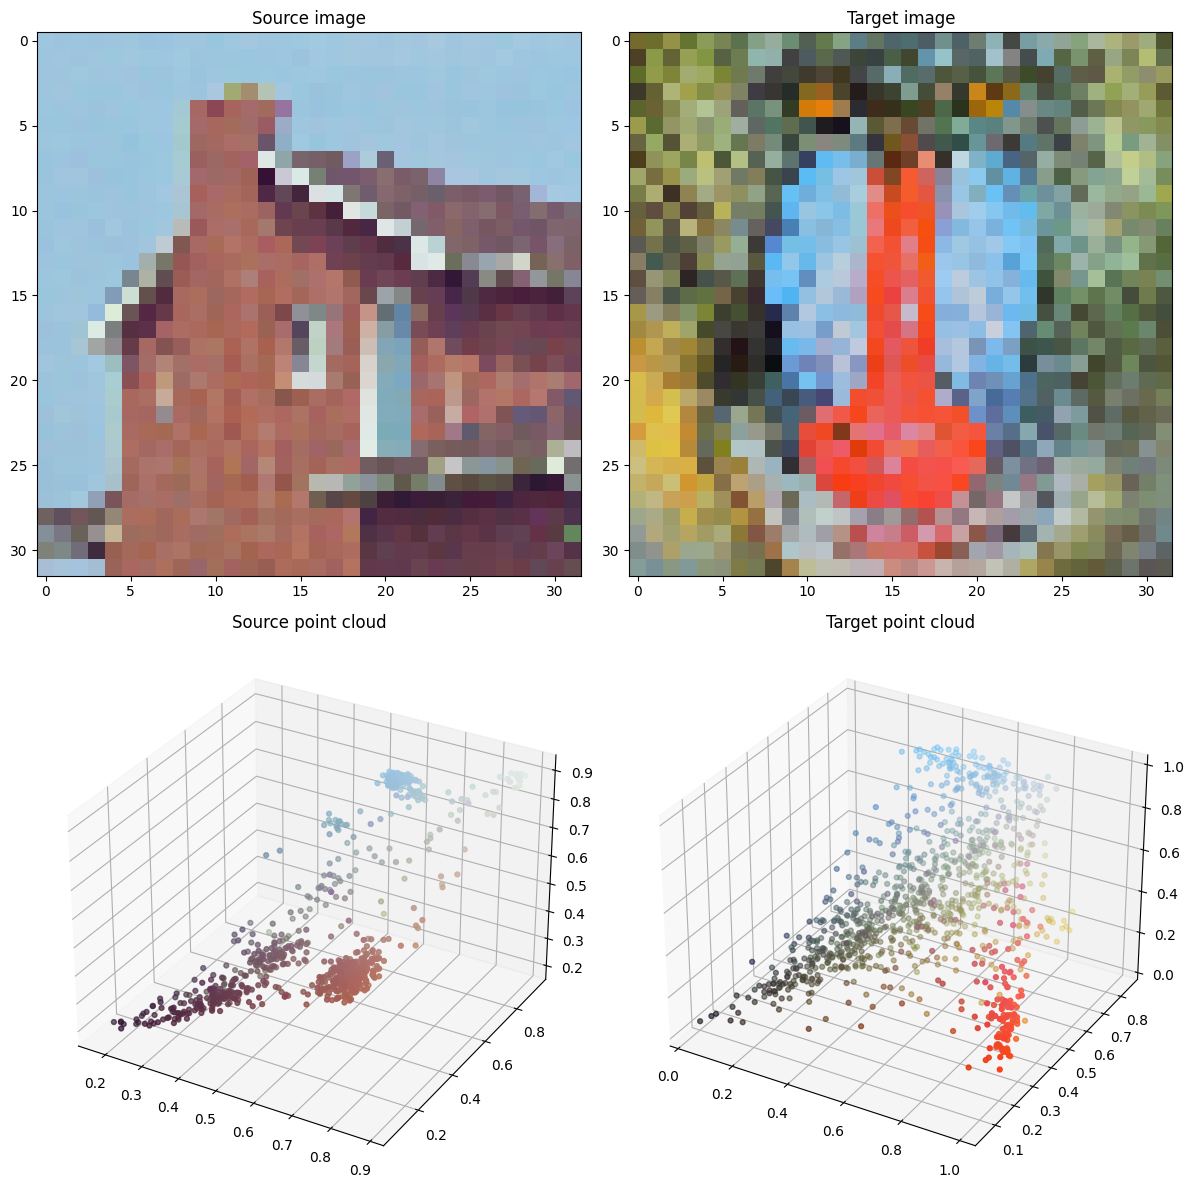

In [77]:
use_cuda = torch.cuda.is_available()
sampling = 8 if not use_cuda else 1
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

X_i = RGB_cloud("../data/house_256.png", sampling, dtype)  # (w//8*h//8, 3)
Y_j = RGB_cloud("../data/mandrill_256.png", sampling, dtype)

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(2, 2, 1)
display_image(ax, X_i)
ax.set_title("Source image")
ax = fig.add_subplot(2, 2, 2)
display_image(ax, Y_j)
ax.set_title("Target image")

ax = fig.add_subplot(2, 2, 3, projection="3d")
display_cloud(ax, X_i)
ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection="3d")
display_cloud(ax, Y_j)
ax.set_title("Target point cloud")
plt.tight_layout()

In [ ]:
def color_transfer_simple(loss_func, lr=1.0):
    num_steps = 11
    display_its = [1, 10]

    x_i, y_j = X_i.clone(), Y_j.clone()
    x_i.requires_grad = True

    t_0 = time.time()

    plt.figure(figsize=(12, 12))
    k = 3
    ax = plt.subplot(2, 2, 1)
    display_image(ax, X_i)
    ax.set_title("Source image")
    ax.axis("off")
    ax = plt.subplot(2, 2, 2)
    display_image(ax, Y_j)
    ax.set_title("Target image")
    ax.axis("off")

    optimizer = optim.SGD([x_i], lr=lr)

    for i in range(num_steps):
        loss = loss_func(x_i, y_j)

        optimizer.zero_grad()
        loss.backward()

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            display_image(ax, x_i)
            ax.set_title("it = {}".format(i))
            k = k + 1
            ax.axis("off")

        optimizer.step()

    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / num_steps)
    )
    plt.tight_layout()

In [107]:
def color_transfer(lr=1.0, eps=0.2):
    """Flows along the gradient of the loss function.

    Parameters:
        loss_func ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    num_steps = 100
    display_its = [1, num_steps - 1]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    n = len(x_i)

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    # step 1
    x_i.requires_grad = True

    t_0 = time.time()

    plt.figure(figsize=(12, 12))
    k = 3
    ax = plt.subplot(2, 2, 1)
    display_image(ax, X_i)
    ax.set_title("Source image")
    ax.axis("off")
    ax = plt.subplot(2, 2, 2)
    display_image(ax, Y_j)
    ax.set_title("Target image")
    ax.axis("off")

    a = torch.ones(n) / n
    b = torch.ones(n) / n

    for it in range(num_steps):  # Euler scheme ===============
        # Compute cost and gradient
        # loss = loss_func(x_i, y_j)
        # step 2
        C = torch.linalg.norm(x_i.unsqueeze(0) - y_j.unsqueeze(1), axis=2)
        # C = pairwise_distances(x_i, y_j, metric="euclidean")
        K = torch.exp(-C / eps)
        u = torch.ones(n)
        for i in range(100):
            v = b / (K.T @ u)
            u = a / (K @ v)

        # step 3
        P = u.reshape(n, 1) * K * v.reshape(1, n)
        loss = (P * C).sum()
        # step 4
        [grad] = torch.autograd.grad(loss, [x_i])

        if it in display_its:  # display
            ax = plt.subplot(2, 2, k)
            display_image(ax, x_i)
            ax.set_title("it = {}".format(it))
            k = k + 1
            ax.axis("off")

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * grad

    # print(grad.shape) # torch.Size([1024, 3])

    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(it, (time.time() - t_0) / num_steps)
    )
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


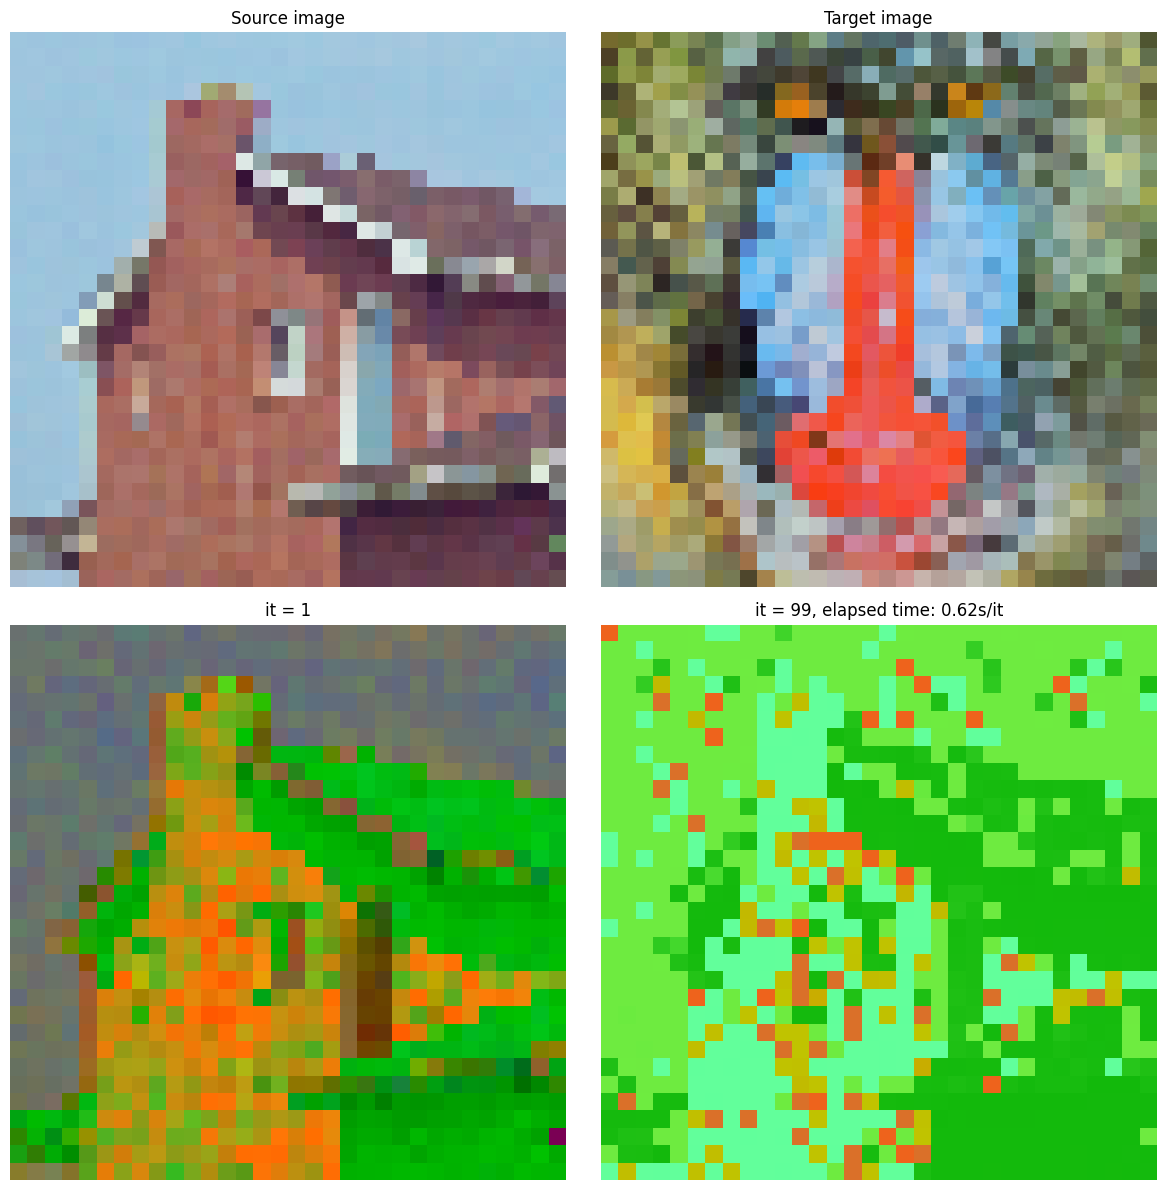

In [108]:
# eps = blur^p
# blur: 0.05
# p: 2
# color_transfer(eps=0.05**2) # black
color_transfer(eps=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


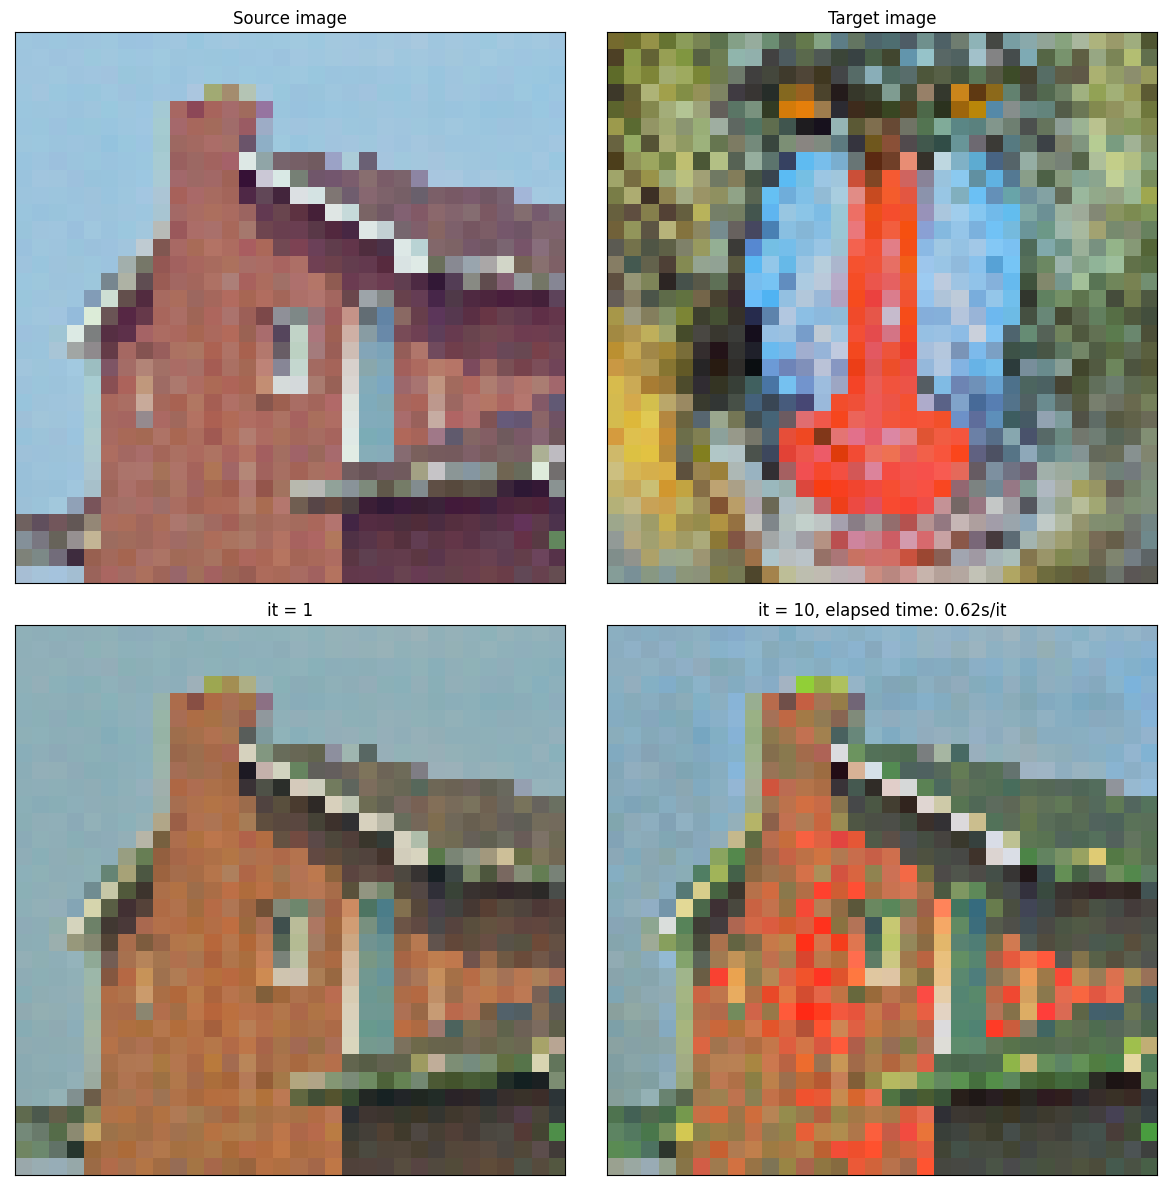

In [38]:
color_transfer_simple(SamplesLoss("sinkhorn", blur=0.3))

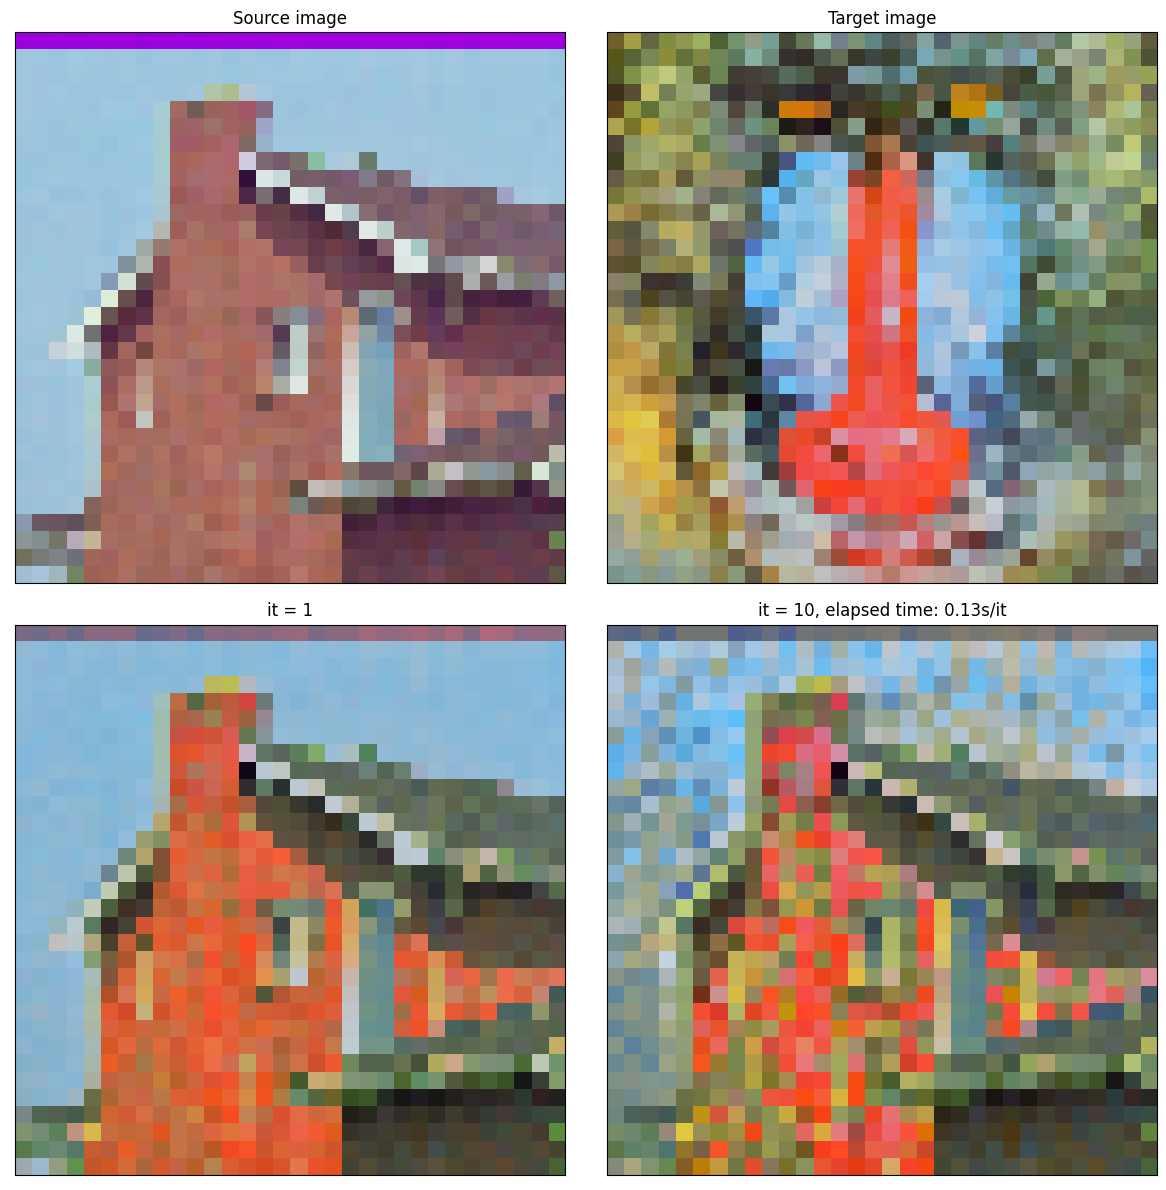

In [16]:
color_transfer_simple(SamplesLoss("sinkhorn", blur=0.1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


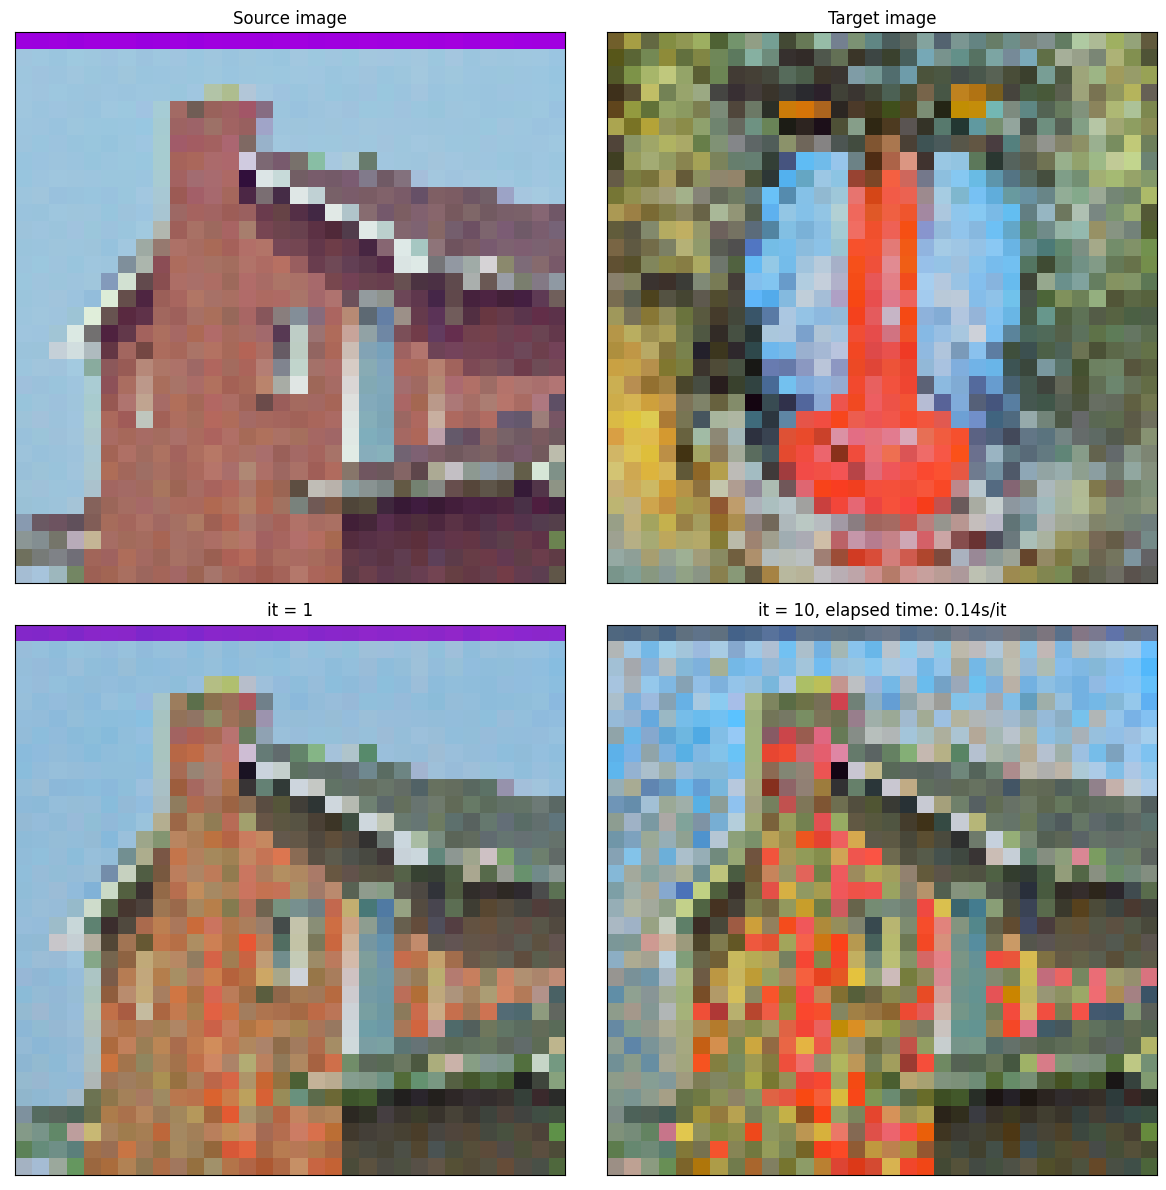

In [17]:
color_transfer_simple(SamplesLoss("sinkhorn", blur=0.1, reach=0.4))

In [ ]:
color_transfer_simple(SamplesLoss("sinkhorn", p=1, blur=0.3))
plt.show()